In [13]:
%%comparing amplitude vs dynamic time warp segmentation of song syllables
% 1. examples of amplitude segmentation of a target motif
% 2. examples of dtw segmentation of a target motif 
% 3. compare the variability of syllable and gap durations measured with both 
% 4. compare the variability of syllable and gap durations when original signals are degraded by pink noise 

% Joanne Cheung, 2017

% path to folder containing song files, syllables already manually labelled (evsonganaly) and stored in .mat files
path  = '/opt/data/from_brad/pk64gr80/';
listoffiles = 'batch'; 

%song parameters
motif = 'cdef';%target motif
load([path,'dtwtemplate']);% example of target motif to use as template for spectral based dtw (make_dtw_temp.m)
load([path,'dtwtemplateAMP'])% example of target motif to use as template for amplitude based dtw (make_dtw2_temp_motif.m)
fs = 44100;%sampling rate
filtype = 'w';%'obs0' or 'w' for cbin or wav files 

%amplitude segmentation parameters
min_int = 5;%minimum length for gaps in ms
min_dur = 20;%minimum length for syllables in ms
thresh = 0.5;%amplitude threshold from 0-1 for segmenting normalized smoothed amp envelop

%for each rendition of target motif, extracts the amp env and syll onsets/offsets using both segmentations
mt = testsegmentation(path,listoffiles,motif,dtwtemplate,dtwtemplateAMP,min_int,min_dur,thresh,'w',44100);

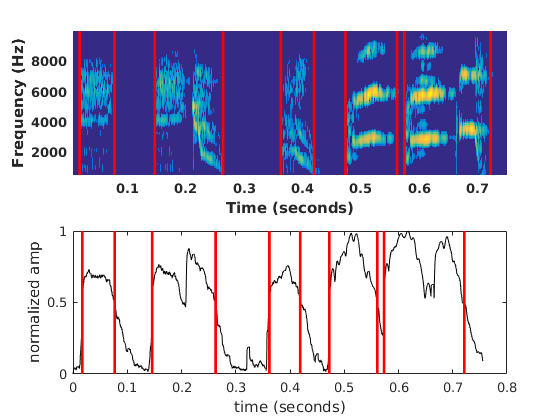

In [17]:
% example of amplitude segmentation
sm = log(mt(1).sm);
sm = sm-min(sm);sm = sm./max(sm);
filtsong = bandpass(mt(1).smtemp,fs,500,10000,'hanningffir');
figure;h = subplot(2,1,1);
jc_spectrogram(filtsong,fs,h);
plot(h,repmat(mt(1).ampsegment(:,1),1,2),[500 10000],'r','linewidth',2);hold on;
plot(h,repmat(mt(1).ampsegment(:,2),1,2),[500 10000],'r','linewidth',2);hold on;
subplot(2,1,2);
tb = [0:length(sm)-1]./fs;
plot(tb,sm,'k');hold on;
plot(repmat(mt(1).ampsegment(:,1),1,2),[0 1],'r','linewidth',2);hold on;
plot(repmat(mt(1).ampsegment(:,2),1,2),[0 1],'r','linewidth',2);hold on;
xlabel('time (seconds)');ylabel('normalized amp')


Amplitude segmentation for each rendition of target motif is done on the normalized smoothed amplitude waveform using a fixed threshold. Each syllable onset and offset boundary is denoted with the red lines. Inconsistent segmentation can arise when the troughs in the amplitude envelop that denote the gaps between syllables don't all fall to  the same level. Here, there were five syllables that were segmented, but the number of segmented syllables can differ from rendition to rendition. Small amplitude fluctuations near the start and ends of syllables can also add noise to the detection of onsets/offsets. 

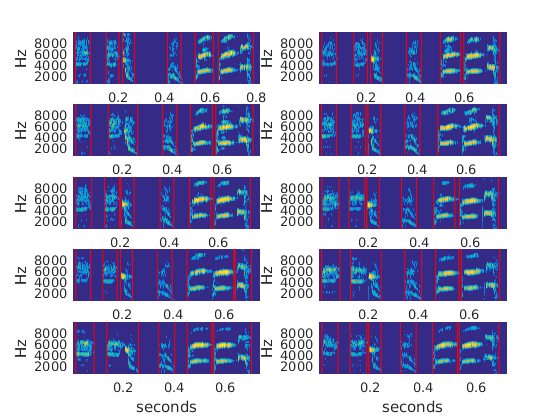

In [22]:
% compare the consistency of amplitude segmentation over several renditions of the motif

sm = arrayfun(@(x) log(x.sm),mt,'un',0);%extract amp env for each trial
filtsong = arrayfun(@(x) bandpass(x.smtemp,fs,500,10000,'hanningffir'),mt,'un',0);
mnvol = cellfun(@mean,sm,'un',1);
[~,ind] = sort(mnvol);
ind = [ind(1:5) ind(end-4:end)];%take the quietest 5 renditions and loudest 5 renditions
figure;
for i = 1:length(ind)
    h = subplot(5,2,i);hold on;
    jc_spectrogram(filtsong{ind(i)},fs,h);
    plot(repmat(mt(ind(i)).ampsegment(:,1),1,2)',[500 10000],'r');hold on;
    plot(repmat(mt(ind(i)).ampsegment(:,2),1,2)',[500 10000],'r');hold on;
end

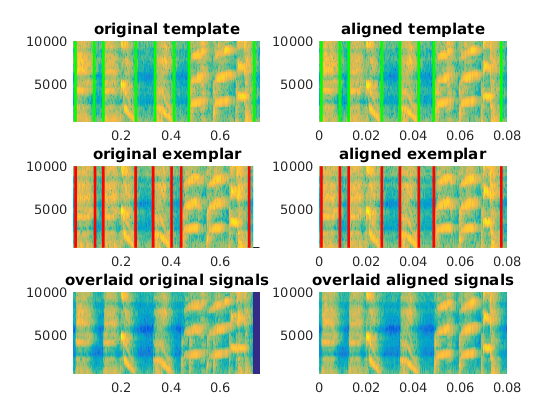

In [33]:
% example of dynamic time warp segmentation 
filtsong = bandpass(mt(5).smtemp,fs,500,10000,'hanningffir');
dtw_segment(filtsong,dtwtemplate,fs,1);


We've chosen one rendition of the target motif to serve as a template. And we've denoted the syllable onsets/offsets for this template (determined by amplitude segmentation of the template). Each exemplar of the motif is then warped to this template and the corresponding syllable onsets/offsets in that exemplar is found. 

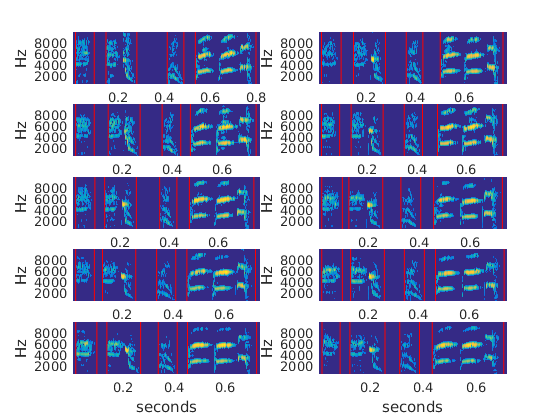

In [37]:
% compare consistency of dtw segmentation for same renditions plotted previously 
filtsong = arrayfun(@(x) bandpass(x.smtemp,fs,500,10000,'hanningffir'),mt,'un',0);
figure;
for i = 1:length(ind)
    h = subplot(5,2,i);hold on;
    jc_spectrogram(filtsong{ind(i)},fs,h);
    plot(repmat(mt(ind(i)).dtwsegment(:,1),1,2)',[500 10000],'r');hold on;
    plot(repmat(mt(ind(i)).dtwsegment(:,2),1,2)',[500 10000],'r');hold on;
end

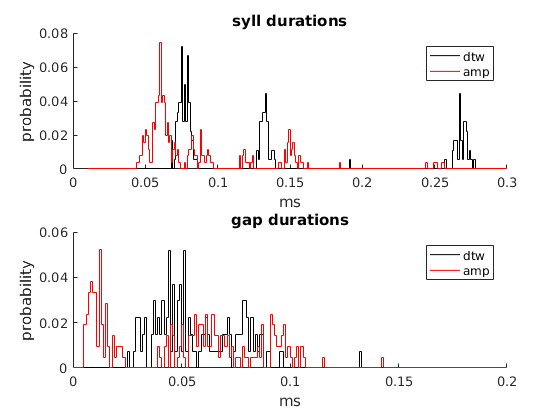

In [51]:
% compare distribution of syllable and gap durations 
dtwsylls = cell2mat(arrayfun(@(x) (x.dtwsegment(:,2)-x.dtwsegment(:,1))',mt,'un',0)');%column = syllable, row = rendition
ampsylls = arrayfun(@(x) (x.ampsegment(:,2)-x.ampsegment(:,1))',mt,'un',0)';
maxlen = max(cellfun(@length,ampsylls));
ampsylls = cell2mat(cellfun(@(x) [x NaN(1,maxlen-length(x))],ampsylls,'un',0));%different number of syllables detected on each motif rendition, pad with NaNs

dtwgaps = cell2mat(arrayfun(@(x) (x.dtwsegment(2:end,1)-x.dtwsegment(1:end-1,2))',mt,'un',0)');
ampgaps = (arrayfun(@(x) (x.ampsegment(2:end,1)-x.ampsegment(1:end-1,2))',mt,'un',0)');
maxlen = max(cellfun(@length,ampgaps));
ampgaps = cell2mat(cellfun(@(x) [x NaN(1,maxlen-length(x))],ampgaps,'un',0));

figure;subplot(2,1,1);hold on;
[n b] = hist(dtwsylls(:),[0.01:0.001:0.300]);
stairs(b,n/sum(n),'k');hold on;
[n b] = hist(ampsylls(:),[0.01:0.001:0.300]);
stairs(b,n/sum(n),'r');hold on;
xlabel('ms');ylabel('probability');title('syll durations');legend({'dtw','amp'});

subplot(2,1,2);hold on;
[n b] = hist(dtwgaps(:),[0:0.001:0.200]);
stairs(b,n/sum(n),'k');hold on;
[n b] = hist(ampgaps(:),[0:0.001:0.200]);
stairs(b,n/sum(n),'r');hold on;
xlabel('ms');ylabel('probability');title('gap durations');legend({'dtw','amp'});

More peaks in the distribution of amplitude segmented motifs reflect inconsistent segmentation of onsets/offsets. Different number of syllables are detected for each rendition of the motif. This is reflected in the average variability of syllable/gap durations as well as the entropy of the gap/syllable distributions. 

In [65]:
% entropy of the distribution of dtw segmented syllable durations
[n b] = hist(dtwsylls(:),[0.01:0.001:0.300]);
n = n./sum(n);
-nansum(n.*log2(n))/log2(length(n))
% entropy of the distribution of amp segmented syllable durations
[n b] = hist(ampsylls(:),[0.01:0.001:0.300]);
n = n./sum(n);
-nansum(n.*log2(n))/log2(length(n))


ans =

    0.6299


ans =

    0.7043



In [67]:
% entropy of the distribution of dtw segmented gap durations
[n b] = hist(dtwgaps(:),[0:0.001:0.300]);
n = n./sum(n);
-nansum(n.*log2(n))/log2(length(n))
% entropy of the distribution of amp segmented gap durations
[n b] = hist(ampgaps(:),[0:0.001:0.300]);
n = n./sum(n);
-nansum(n.*log2(n))/log2(length(n))


ans =

    0.6921


ans =

    0.7227



The entropy of syll/gap distributions shows that dtw segmentation produces more consistent syllable and gap durations. This suggests more consistent detection of onsets and offsets from rendition to rendition of the motif using dtw. The entropy measure reflects both the inconsistent segmentation of the number of syllables as well as inconsistent segmentation of a particular syllable from rendition to rendition. 

In [91]:
% test consistency of segmentation when original signal is degraded by pink noise
% this is because signal to noise ratio (which is correlated with volume) fluctuates from rendition to rendition
% and this may drive biases when using amplitude to segment motifs since the shape of the amplitude envelop
% may be affected. But lower signal to noise also degrades spectral structure, so it is unclear if dtw would be 
% more robust under noisy conditions. Specifically, we want to know if adding noise differentially increases 
% segmentation inconsistency for amp vs dtw segmentation. In addition, does adding noise also systematically bias 
% segmentation for both amp and dtw segmentation. 

% add 0 dB pink noise to each sound chunk for every amplitude envelop 
ampnoise = cell(length(filtsong),1);
dtwnoise = cell(length(filtsong),1);
filtsongnoise = cell(length(filtsong),1);
for i = 1:length(filtsong)
    len = length(filtsong{i});
    cn = dsp.ColoredNoise('Color','pink','SamplesPerFrame',NFFT);
    winid = 1;filtandnoise = [];
    while length(filtandnoise)<len
        if winid+NFFT-1 < len
            audioRMS = rms(filtsong{i}(winid:winid+NFFT-1));
            noise = cn();
            noiseRMS = rms(noise);
            noise = noise*(audioRMS/noiseRMS);
            filtandnoise = [filtandnoise; filtsong{i}(winid:winid+NFFT-1)+noise];
            winid = winid+NFFT;
        else
            len = length(filtsong{i}(winid:len));
            audioRMS = rms(filtsong{i}(winid:winid+len-1));
            cn = dsp.ColoredNoise('Color','pink','SamplesPerFrame',len);
            noise = cn();
            noiseRMS = rms(noise);
            noise = noise*(audioRMS/noiseRMS);
            filtandnoise = [filtandnoise; filtsong{i}(winid:winid+len-1)+noise];
        end
    end
    sm = evsmooth(filtandnoise,fs,'','',5);
    sm=log(sm);sm=sm-min(sm);sm=sm./max(sm);
    [ons offs] = SegmentNotes(sm,fs,5,20,0.5);
    ampnoise{i} = [ons offs];
    [ons offs] = dtw_segment(filtandnoise,dtwtemplate,fs);
    dtwnoise{i} = [ons offs];
    filtsongnoise{i} = filtandnoise;
end

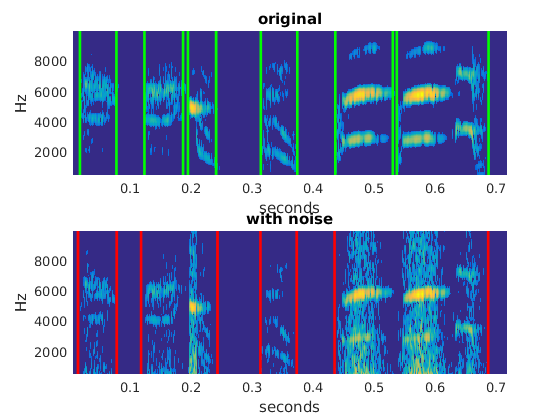

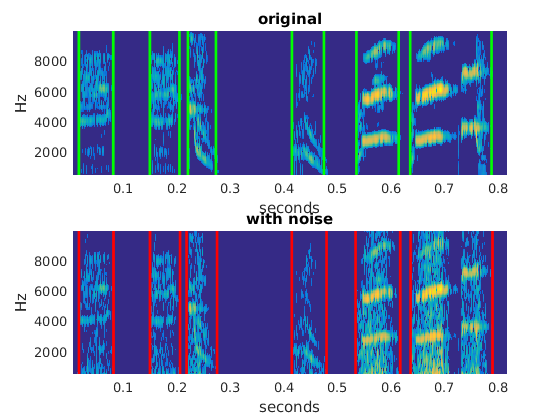

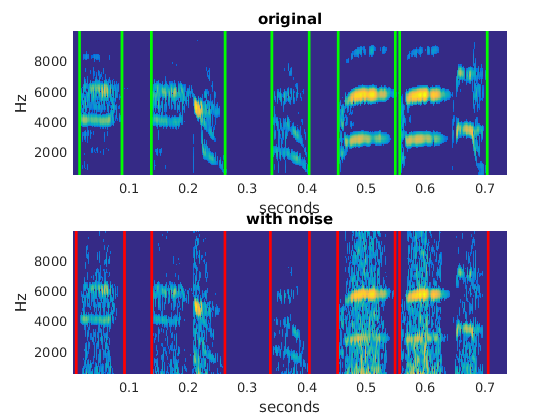

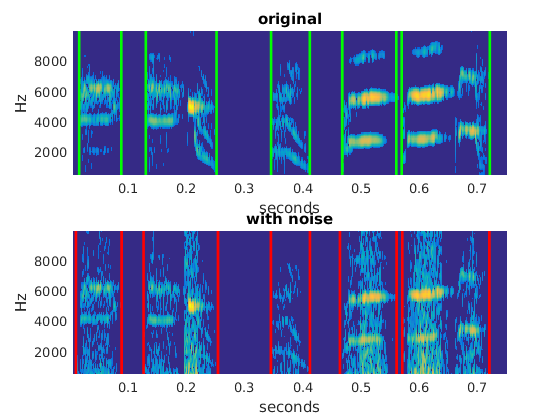

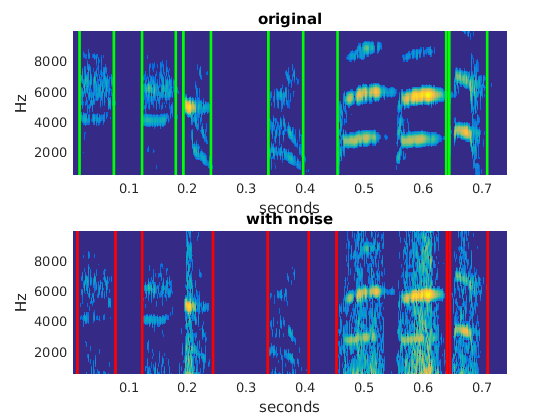

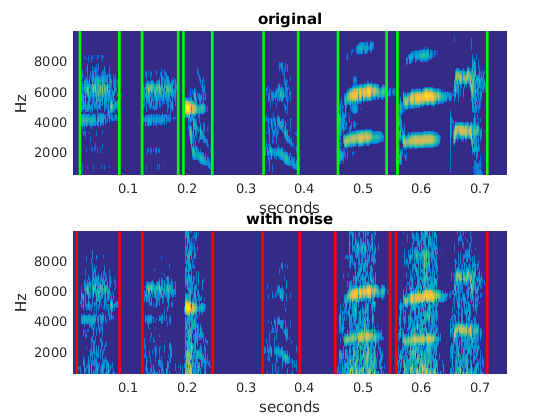

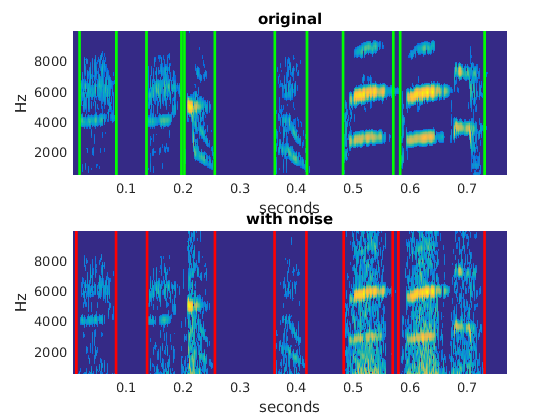

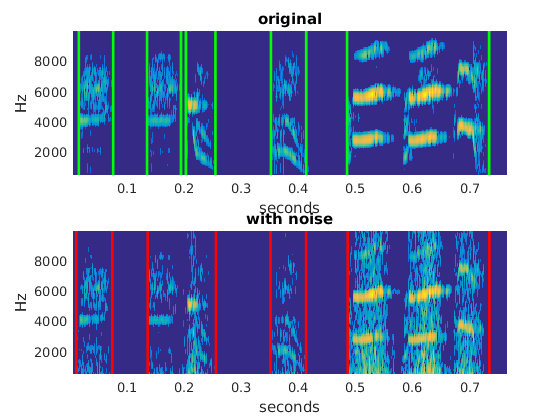

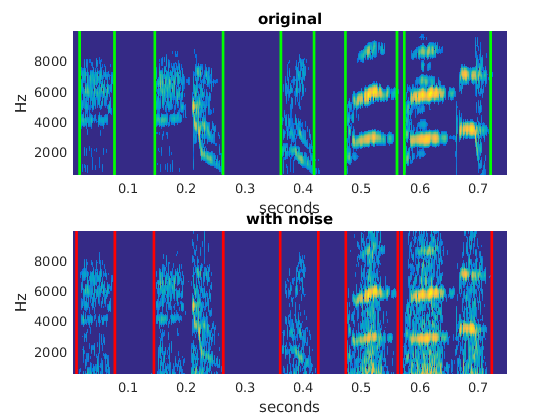

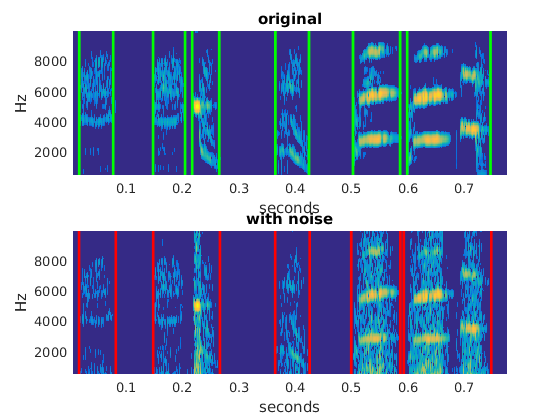

In [102]:
% compare amp segmentation on examples with noise added
for i = 1:length(ind)
    figure;
    h = subplot(2,1,1);hold on;
    jc_spectrogram(filtsong{ind(i)},fs,h);
    plot(repmat(mt(ind(i)).ampsegment(:,1),1,2)',[500 10000],'g','linewidth',2);hold on;
    plot(repmat(mt(ind(i)).ampsegment(:,2),1,2)',[500 10000],'g','linewidth',2);hold on;
    title('original')
    h = subplot(2,1,2);hold on;
    jc_spectrogram(filtsongnoise{ind(i)},fs,h);
    plot(repmat(ampnoise{ind(i)}(:,1),1,2)',[500 10000],'r','linewidth',2);hold on;
    plot(repmat(ampnoise{ind(i)}(:,2),1,2)',[500 10000],'r','linewidth',2);hold on;
    title('with noise')
end

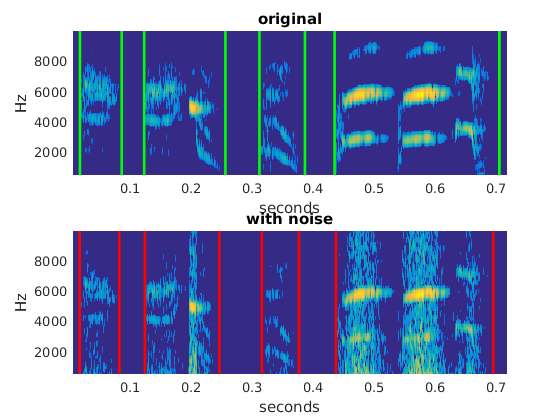

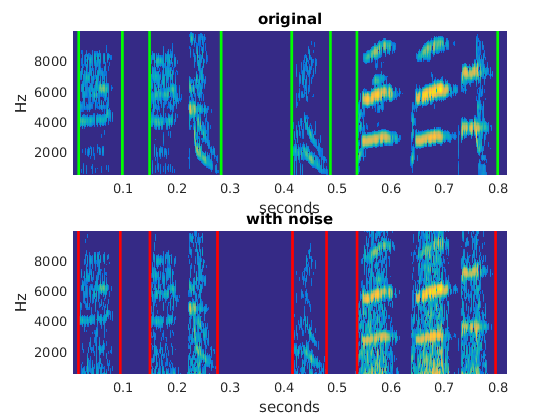

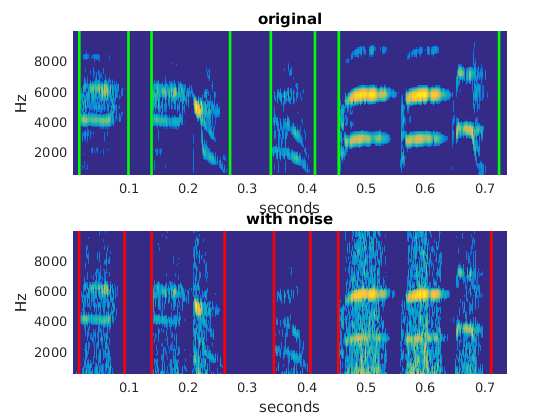

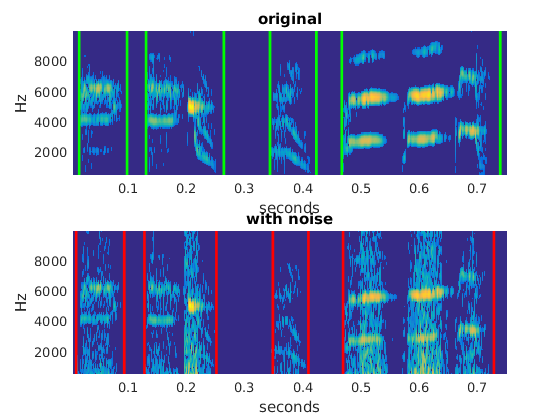

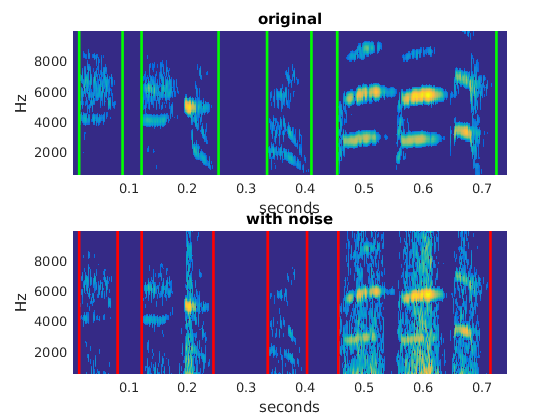

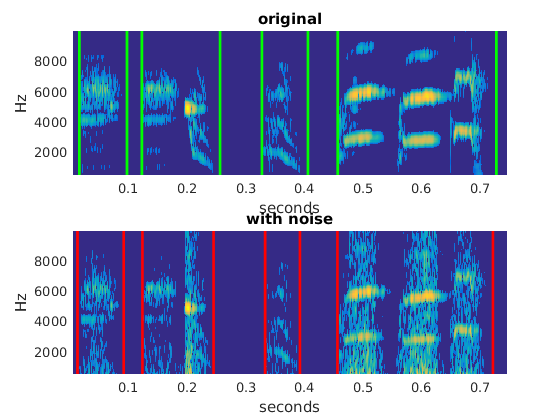

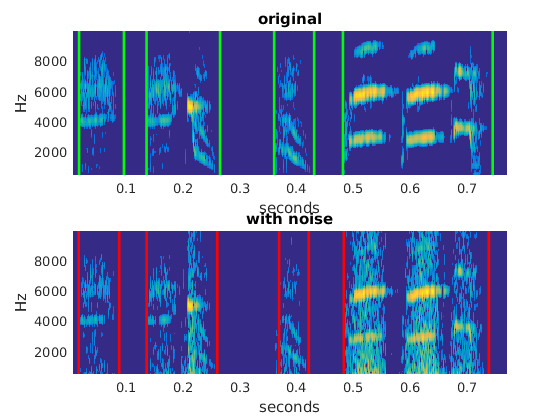

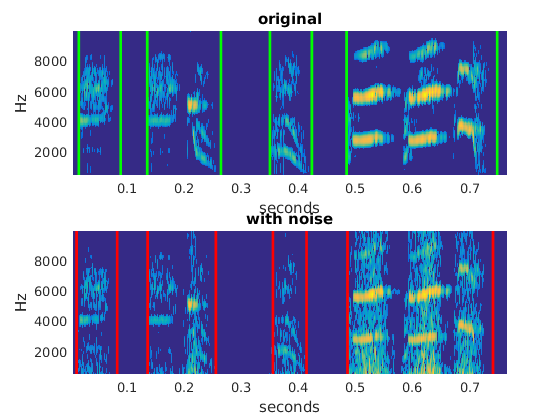

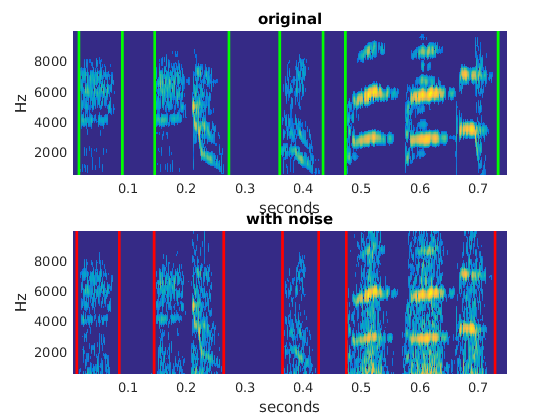

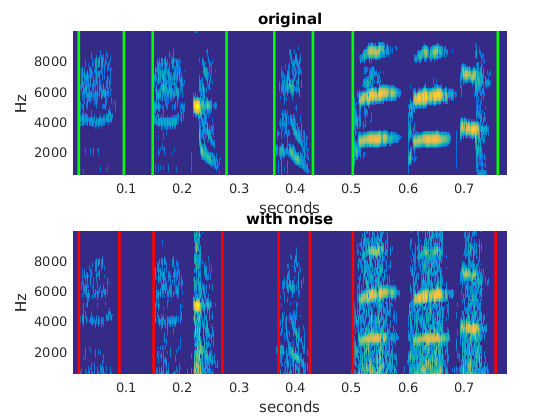

In [103]:
% compare dtw segmentation on examples with noise added
for i = 1:length(ind)
    figure;
    h = subplot(2,1,1);hold on;
    jc_spectrogram(filtsong{ind(i)},fs,h);
    plot(repmat(mt(ind(i)).dtwsegment(:,1),1,2)',[500 10000],'g','linewidth',2);hold on;
    plot(repmat(mt(ind(i)).dtwsegment(:,2),1,2)',[500 10000],'g','linewidth',2);hold on;
    title('original')
    h = subplot(2,1,2);hold on;
    jc_spectrogram(filtsongnoise{ind(i)},fs,h);
    plot(repmat(dtwnoise{ind(i)}(:,1),1,2)',[500 10000],'r','linewidth',2);hold on;
    plot(repmat(dtwnoise{ind(i)}(:,2),1,2)',[500 10000],'r','linewidth',2);hold on;
    title('with noise')
end

In [105]:
% gap and syllable durations for each rendition of the motif corrupted with noise
dtwnoisesylls = cell2mat(cellfun(@(x) (x(:,2)-x(:,1))',dtwnoise,'un',0));
ampnoisesylls = cellfun(@(x) (x(:,2)-x(:,1))',ampnoise,'un',0);
maxlen = max(cellfun(@length,ampnoisesylls));
ampnoisesylls = cell2mat(cellfun(@(x) [x NaN(1,maxlen-length(x))],ampnoisesylls,'un',0));

dtwnoisegaps = cell2mat(cellfun(@(x) (x(2:end,1)-x(1:end-1,2))',dtwnoise,'un',0));
ampnoisegaps = cellfun(@(x) (x(2:end,1)-x(1:end-1,2))',ampnoise,'un',0);
maxlen = max(cellfun(@length,ampnoisegaps));
ampnoisegaps = cell2mat(cellfun(@(x) [x NaN(1,maxlen-length(x))],ampnoisegaps,'un',0));

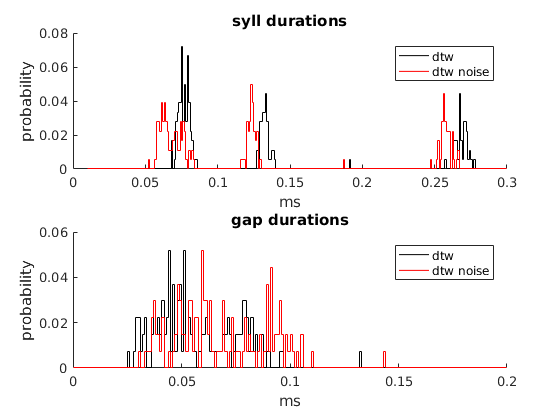

In [79]:
% gap and syllable distributions segmented by dtw for original signals vs corrupted signals
figure;subplot(2,1,1);hold on;
[n b] = hist(dtwsylls(:),[0.01:0.001:0.300]);
stairs(b,n/sum(n),'k');hold on;
[n b] = hist(dtwnoisesylls(:),[0.01:0.001:0.300]);
stairs(b,n/sum(n),'r');hold on;
xlabel('ms');ylabel('probability');title('syll durations');legend({'dtw','dtw noise'});

subplot(2,1,2);hold on;
[n b] = hist(dtwgaps(:),[0:0.001:0.200]);
stairs(b,n/sum(n),'k');hold on;
[n b] = hist(dtwnoisegaps(:),[0:0.001:0.200]);
stairs(b,n/sum(n),'r');hold on;
xlabel('ms');ylabel('probability');title('gap durations');legend({'dtw','dtw noise'});

In [106]:
% entropy of the distribution of dtw segmented syllable durations for original signals
[n b] = hist(dtwsylls(:),[0.01:0.001:0.300]);
n = n./sum(n);
-nansum(n.*log2(n))/log2(length(n))
% entropy of the distribution of dtw segmented syllable durations for corrupted signals
[n b] = hist(dtwnoisesylls(:),[0.01:0.001:0.300]);
n = n./sum(n);
-nansum(n.*log2(n))/log2(length(n))


ans =

    0.6299


ans =

    0.6597



In [109]:
% entropy of the distribution of dtw segmented gap durations for original signals
[n b] = hist(dtwgaps(:),[0:0.001:0.300]);
n = n./sum(n);
-nansum(n.*log2(n))/log2(length(n))
% entropy of the distribution of dtw segmented gap durations for corrupted signals
[n b] = hist(dtwnoisegaps(:),[0:0.001:0.300]);
n = n./sum(n);
-nansum(n.*log2(n))/log2(length(n))


ans =

    0.6921


ans =

    0.7069



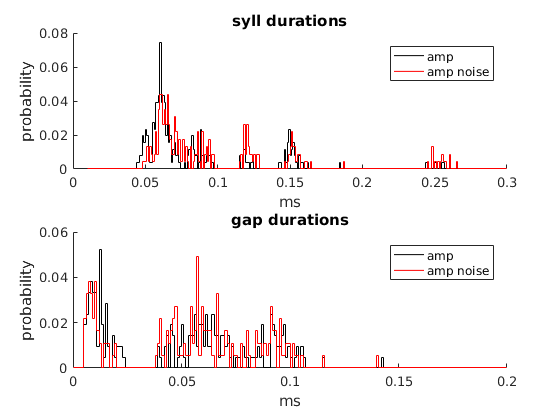

In [107]:
% gap and syllable distributions segmented by amp for original signals vs corrupted signals
figure;subplot(2,1,1);hold on;
[n b] = hist(ampsylls(:),[0.01:0.001:0.300]);
stairs(b,n/sum(n),'k');hold on;
[n b] = hist(ampnoisesylls(:),[0.01:0.001:0.300]);
stairs(b,n/sum(n),'r');hold on;
xlabel('ms');ylabel('probability');title('syll durations');legend({'amp','amp noise'});

subplot(2,1,2);hold on;
[n b] = hist(ampgaps(:),[0:0.001:0.200]);
stairs(b,n/sum(n),'k');hold on;
[n b] = hist(ampnoisegaps(:),[0:0.001:0.200]);
stairs(b,n/sum(n),'r');hold on;
xlabel('ms');ylabel('probability');title('gap durations');legend({'amp','amp noise'});

In [108]:
% entropy of the distribution of amp segmented syllable durations for original signals
[n b] = hist(ampsylls(:),[0.01:0.001:0.300]);
n = n./sum(n);
-nansum(n.*log2(n))/log2(length(n))
% entropy of the distribution of amp segmented syllable durations for corrupted signals
[n b] = hist(ampnoisesylls(:),[0.01:0.001:0.300]);
n = n./sum(n);
-nansum(n.*log2(n))/log2(length(n))


ans =

    0.7043


ans =

    0.7274



In [110]:
% entropy of the distribution of amp segmented gap durations for original signals
[n b] = hist(ampgaps(:),[0:0.001:0.300]);
n = n./sum(n);
-nansum(n.*log2(n))/log2(length(n))
% entropy of the distribution of amp segmented gap durations for corrupted signals
[n b] = hist(ampnoisegaps(:),[0:0.001:0.300]);
n = n./sum(n);
-nansum(n.*log2(n))/log2(length(n))


ans =

    0.7227


ans =

    0.7133



In [112]:
% comparing shift in the syll distribution for dtw segmentation for original vs corrupted signals
p = ranksum(dtwsylls(:),dtwnoisesylls(:))
mean(dtwsylls(:))
mean(dtwnoisesylls(:))


p =

   6.5460e-06


ans =

    0.1377


ans =

    0.1283



In [113]:
% comparing shift in the gap distribution for dtw segmentation for original vs corrupted signals
p = ranksum(dtwgaps(:),dtwnoisegaps(:))
mean(dtwgaps(:))
mean(dtwnoisegaps(:))


p =

   6.6616e-05


ans =

    0.0573


ans =

    0.0674



In [115]:
% comparing shift in the syll distribution for amp segmentation for original vs corrupted signals
p = ranksum(ampsylls(:),ampnoisesylls(:))
nanmean(ampsylls(:))
nanmean(ampnoisesylls(:))


p =

   4.3679e-06


ans =

    0.0835


ans =

    0.0976



In [117]:
% comparing shift in the gap distribution for amp segmentation for original vs corrupted signals
p = ranksum(ampgaps(:),ampnoisegaps(:))
nanmean(ampgaps(:))
nanmean(ampnoisegaps(:))


p =

    0.5655


ans =

    0.0497


ans =

    0.0531

